# 7. AutoML : Utilisation AutoML d'Azure ML service depuis Azure Databricks

Dans cet exemple, nous utilisons un jeu de données de scikit-learn (http://scikit-learn.org/stable/datasets/index.html#optical-recognition-of-handwritten-digits-dataset) pour montrer comment vous pouvez utiliser AutoML pour un problème de classification simple.

Dans ce notebook, vous apprendrez à :
1. Créez l'objet Azure Machine Learning Workspace et initialisez le répertoire de votre ordinateur pour recharger facilement cet objet depuis un fichier de configuration.
2. Créer une Expérience dans un Espace de Travail existant.
3. Configurez AutoML en utilisant `AutoMLConfig`.
4. Formez le modèle à l'aide d'Azure DataBricks.
5. Explorez les résultats.
6. Tester le modèle le mieux adapté.

#### Note : Appel des fonctions AutoML Azure ML service
> Définir la librairie suivante au cluster Databrick pour utiliser les fonctions Auto ML de Azure ML service :
**azureml-sdk[automl_databricks]**

### 1. Informations

In [4]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)
print()
import sys
print("Version Python : ",sys.version)
print()
print("Spark Context :")
sc

Version Azure ML service : 1.0.2

Version Python : 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]

Spark Context :
 Out[ 45 ]: <SparkContext master=spark://10.139.64.4:7077 appName=Databricks Shell>

## 2. Connexion Azure ML service workspace

In [6]:
subscription_id = "70b8f39e-8863-49f7-b6ba-34a80799550c"
resource_group = "resgrpAMLS"
workspace_name = "AMLSworkspace"
workspace_region = "westeurope" #eg. eastus2, westcentralus, westeurope


In [7]:
from azureml.core import Workspace
import azureml.core

ws = Workspace.from_config()
print()
print('Nom du workspace : ' + ws.name, 
      'Région Azure : ' + ws.location, 
      'Subscription ID : ' + ws.subscription_id, 
      'Ressource groupe : ' + ws.resource_group, sep = '\n')

Found the config file in: /databricks/driver/aml_config/config.json

Nom du workspace : MLServiceWorkspace
Région Azure : westeurope
Subscription ID : 70b8f39e-8863-49f7-b6ba-34a80799550c
Ressource groupe : mlserviceresourcegroup

## 3. Création répertoire des données

In [9]:
import os

sample_projects_folder = './sample_projects'

if not os.path.isdir(sample_projects_folder):
    os.mkdir(sample_projects_folder)
    
print('Les données seront stockées ici : {}.'.format(sample_projects_folder))

Les données seront stockées ici : ./sample_projects.

## 4. Création de l'expérimentation

In [11]:
import logging
import os
import random
import time

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

Définition expérimentation

In [13]:
experiment_name = 'automl-local-classification'
project_folder = './sample_projects/automl-local-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['Version Azure ML service :'] = azureml.core.VERSION
output['Subscription ID :'] = ws.subscription_id
output['Nom workspace :'] = ws.name
output['Ressource Groupe :'] = ws.resource_group
output['Localisation :'] = ws.location
output['Répertoire :'] = project_folder
output['Nom expérimentation :'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

Out[ 50 ]: 
 
Localisation : westeurope 
Nom expérimentation : automl-local-classification 
Nom workspace : MLServiceWorkspace 
Ressource Groupe : mlserviceresourcegroup 
Répertoire : ./sample_projects/automl-local-classification
Subscription ID : 70b8f39e-8863-49f7-b6ba-34a80799550c 
Version Azure ML service : 1.0.2

## 4.1 Données de télémétrie

In [15]:
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

## 4.2 Chargement des données

In [17]:
import azureml.dataprep as dprep
# You can use `auto_read_file` which intelligently figures out delimiters and datatypes of a file.
# The data referenced here was pulled from `sklearn.datasets.load_digits()`.

simple_example_data_root = 'https://dprepdata.blob.core.windows.net/automl-notebook-data/'
X_train = dprep.auto_read_file(simple_example_data_root + 'X.csv').skip(1)  # Remove the header row.

# You can also use `read_csv` and `to_*` transformations to read (with overridable delimiter)
# and convert column types manually.
# Here we read a comma delimited file and convert all columns to integers.

y_train = dprep.read_csv(simple_example_data_root + 'y.csv').to_long(dprep.ColumnSelector(term='.*', use_regex = True))

In [18]:
X_train.skip(1).head(10)

Out[ 53 ]: 
 Column1 Column2 Column3 ... Column62 Column63 Column64
0 0.0 0.0 0.0 ... 10.0 0.0 0.0 
1 0.0 0.0 0.0 ... 16.0 9.0 0.0 
2 0.0 0.0 7.0 ... 9.0 0.0 0.0 
3 0.0 0.0 0.0 ... 4.0 0.0 0.0 
4 0.0 0.0 12.0 ... 10.0 0.0 0.0 
5 0.0 0.0 0.0 ... 11.0 3.0 0.0 
6 0.0 0.0 7.0 ... 0.0 0.0 0.0 
7 0.0 0.0 9.0 ... 11.0 1.0 0.0 
8 0.0 0.0 11.0 ... 3.0 0.0 0.0 
9 0.0 0.0 1.0 ... 3.0 0.0 0.0 

[10 rows x 64 columns]

## 5. Configuration AutoML

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**spark_context**|Spark Context object. for Databricks, use spark_context=sc|
|**max_cuncurrent_iterations**|Maximum number of iterations to execute in parallel. This should be less than the number of cores on the ADB..|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], [n_samples, n_classes]<br>Multi-class targets. An indicator matrix turns on multilabel classification. This should be an array of integers.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|
|**concurrent_iterations**|number of concurrent runs <= total cores in all worker nodes in your Databricks cluster|
|**exit_score**|Target score for experiment. It is associated with the metric. eg. exit_score=0.995 will exit experiment after that|

> Plus d'informations :<br> 
https://azure.microsoft.com/en-us/blog/new-automated-machine-learning-capabilities-in-azure-machine-learning-service/
<br>
<br>
> Documentation Azure ML service AutoML : <br>
https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml

In [21]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 5,
                             iterations = 10,
                             n_cross_validations = 3,
                             max_concurrent_iterations = 8, #change it based on number of cores in worker nodes
                             verbosity = logging.INFO,
                             spark_context=sc, #databricks/spark related
                             X = X_train, 
                             y = y_train,
                             enable_cache=False,
                             path = project_folder)

## 6. Exécution AutoML

In [23]:
local_run = experiment.submit(automl_config, show_output = True)

Running on ADB cluster experiment automl-local-classification.Parent Run ID: AutoML_90d53385-ba3d-4461-8bc8-ef6f57d2bd93
*******************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************

 ITERATION PIPELINE DURATION METRIC BEST
 0 StandardScalerWrapper KNN 0:00:14 0.9979 0.9979
 1 StandardScalerWrapper KNN 0:00:13 0.9984 0.9984
 2 MaxAbsScaler LightGBM 0:00:14 0.9960 0.9984
 3 StandardScalerWrapper LightGBM 0:00:12 0.9931 0.9984
 4 PCA LogisticRegression 0:00:11 0.8309 0.9984
 5 RobustScaler LightGBM 0:00:11 0.9836 0.9984
 7 MinMaxScaler ExtremeRandomTrees 0:00:14 0.9748 0.9984
 6 RobustScaler LightGBM 0:00:22 0.9964 0.9984
 9 SparseNormalizer LightGBM 0:00:20 0.9975 0.9984
 8 SparseNormalizer LightGBM 0:00:30 0.9985 0.9985

## 7. Exploration des résultats

#### 7.1 Lien sur widget Portail Azure

Accéder au lien généré pour visualiser les détails de l'autoML depuis le portail Azure

In [26]:
print("Lien du widget AutoML du portail Azure :")
print(local_run.get_portal_url())

Lien du widget AutoML du portail Azure :
https://mlworkspace.azure.ai/portal/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/mlserviceresourcegroup/providers/Microsoft.MachineLearningServices/workspaces/MLServiceWorkspace/experiments/automl-local-classification/runs/AutoML_90d53385-ba3d-4461-8bc8-ef6f57d2bd93

####7.2 Récupération de toutes les itérations AutoML

In [28]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}    
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

Out[ 57 ]: 
 0 ... 9
AUC_macro 0.997908 ... 0.997549
AUC_micro 0.998099 ... 0.997674
AUC_weighted 0.997880 ... 0.997540
AUC_weighted_max 0.997880 ... 0.997540
accuracy 0.967168 ... 0.938230
average_precision_score_macro 0.990185 ... 0.984763
average_precision_score_micro 0.991152 ... 0.986022
average_precision_score_weighted 0.990244 ... 0.985015
balanced_accuracy 0.967578 ... 0.938079
f1_score_macro 0.967275 ... 0.937268
f1_score_micro 0.967168 ... 0.938230
f1_score_weighted 0.967110 ... 0.938512
log_loss 0.201682 ... 0.272591
norm_macro_recall 0.963976 ... 0.931198
precision_score_macro 0.967790 ... 0.938130
precision_score_micro 0.967168 ... 0.938230
precision_score_weighted 0.967901 ... 0.940411
recall_score_macro 0.967578 ... 0.938079
recall_score_micro 0.967168 ... 0.938230
recall_score_weighted 0.967168 ... 0.938230
weighted_accuracy 0.966741 ... 0.938308

[21 rows x 10 columns]

### 7.3 Récupération du meilleur modèle

In [30]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automl-local-classification,
Id: AutoML_90d53385-ba3d-4461-8bc8-ef6f57d2bd93_8,
Type: None,
Status: Completed)
Pipeline(memory=None,
 steps=[('SparseNormalizer', <automl.client.core.common.model_wrappers.SparseNormalizer object at 0x7ff7ad0d7cf8>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7ff7ad0db898>)])

#### 7.3 Changement de la métrique de choix de modèle
Utilisation de la métrique `log_loss`

In [32]:
lookup_metric = "log_loss"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)

print(best_run)
print()
print(fitted_model)

Run(Experiment: automl-local-classification,
Id: AutoML_90d53385-ba3d-4461-8bc8-ef6f57d2bd93_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
 steps=[('SparseNormalizer', <automl.client.core.common.model_wrappers.SparseNormalizer object at 0x7ff7ac304710>), ('LightGBMClassifier', <automl.client.core.common.model_wrappers.LightGBMClassifier object at 0x7ff7ce72fc18>)])

### 8. Evaluation du modèle

In [34]:
from sklearn import datasets
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

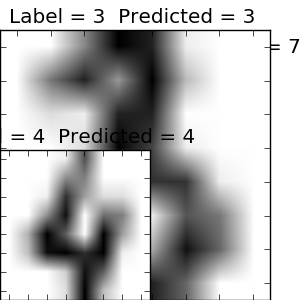

In [35]:
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label value = %d  Predicted value = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    
    display(fig)

> Fin